# Importing packages for analysis

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

#Package used to make word clouds
!pip install wordcloud
from wordcloud import WordCloud

#Library to perform MANOVA

#Library to perfom PCA
from sklearn.decomposition import PCA


print('Libraries imported.')

# Making contact with the Foursquare API

In [1]:
CLIENT_ID = '3D4LENXHHOBJFOW2412OIA5NLI0TUN3H4YOUKVHIUP0BICR3' # your Foursquare ID
CLIENT_SECRET = 'HQYRGK0KHC4SIWLSMN423ZA1AEZWA2A5O5VHUOH2TOVQXWAA' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3D4LENXHHOBJFOW2412OIA5NLI0TUN3H4YOUKVHIUP0BICR3
CLIENT_SECRET:HQYRGK0KHC4SIWLSMN423ZA1AEZWA2A5O5VHUOH2TOVQXWAA


In [2]:
#Geolocation cordinates for Leuven, Belgium
Leuven_lat=50.8798
Leuven_long=4.7005

LIMIT=100
radius = 2500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Leuven_lat, 
    Leuven_long, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=3D4LENXHHOBJFOW2412OIA5NLI0TUN3H4YOUKVHIUP0BICR3&client_secret=HQYRGK0KHC4SIWLSMN423ZA1AEZWA2A5O5VHUOH2TOVQXWAA&v=20200101&ll=50.8798,4.7005&radius=2500&limit=100'

In [ ]:
#Obtaining the data from foursquare and converting it to JSON format
results = requests.get(url).json()
results

# Data preprocessing from JSON format

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
venues = results['response']['groups'][0]['items'] #Obtainig the features from the JSON object


nearby_venues = json_normalize(venues) # flatten JSON into dataframe

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Den Boule,Bar,50.881367,4.701515
1,Bistro Tribunal,Bistro,50.880845,4.701951
2,Oude Markt,Plaza,50.878478,4.699780
3,De Optimist,Bar,50.881510,4.699874
4,Barbóék,Coffee Shop,50.880989,4.701104


In [8]:
print("First {} random venues in 2500m radius".format(len(list(set(nearby_venues["name"])))))

First 99 random venues in 2500m radius


In [9]:
#Function to obtain neighborhoods, venues, vebue categories and their geolocation cordinates 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
#Applying the above function on data
Leuven_venues = getNearbyVenues(names=nearby_venues['name'],
                                   latitudes=nearby_venues['lat'],
                                   longitudes=nearby_venues['lng']
                                  )
Leuven_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Den Boule,50.881367,4.701515,Den Boule,50.881367,4.701515,Bar
1,Den Boule,50.881367,4.701515,Bistro Tribunal,50.880845,4.701951,Bistro
2,Den Boule,50.881367,4.701515,De Optimist,50.881510,4.699874,Bar
3,Den Boule,50.881367,4.701515,Barbóék,50.880989,4.701104,Coffee Shop
4,Den Boule,50.881367,4.701515,Kaasambacht Elsen,50.880821,4.699688,Cheese Shop


The following word cloud is a summary of the venue categories. The size of the words is proportional to the occurence of the category in the obtained dataset

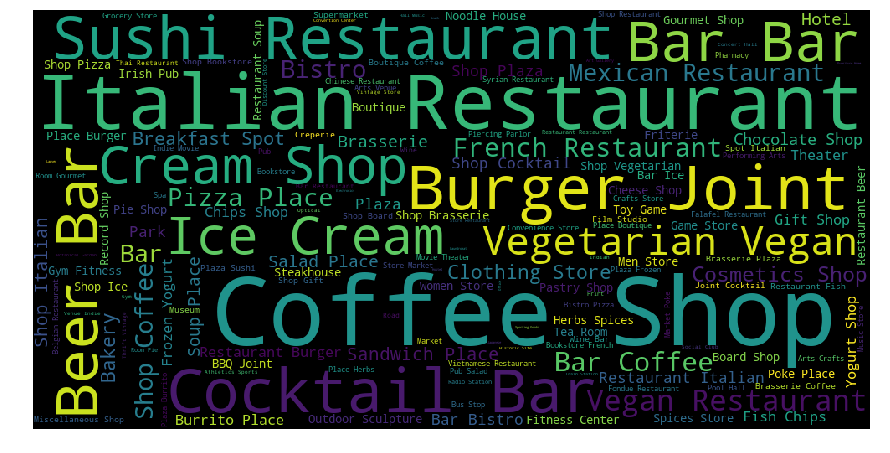

In [13]:
unique_string=(" ").join(Leuven_venues["Venue Category"]) #Obtaining venues seperated by space character
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string) #Creating a wordcloud object
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

In [16]:
print("Number of venue categories: ",len(list(set(Leuven_venues["Venue Category"]))))
print("Number of Neighborhoods: ",len(list(set(Leuven_venues["Neighborhood"]))))

Number of venue categories:  142
Number of Neighborhoods:  99


Visualising the neighborhoods

In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [ ]:
# create map of Leuven using latitude and longitude values
map_leuven = folium.Map(location=[Leuven_lat, Leuven_long], zoom_start=14)

# add markers to map
for lat, lng, label in zip(Leuven_venues['Neighborhood Latitude'], Leuven_venues['Neighborhood Longitude'], Leuven_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_leuven)  
    
map_leuven

## Preparing data to be used for clustering 

In [11]:
# one hot encoding
leuven_bus_dums = pd.get_dummies(Leuven_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
leuven_bus_dums['Neighborhood'] = Leuven_venues['Neighborhood'] 
leuven_bus_dums['Venue']=Leuven_venues['Venue']

# move neighborhood column to the first column
fixed_columns = [leuven_bus_dums.columns[-2],leuven_bus_dums.columns[-1]] + list(leuven_bus_dums.columns[:-2])
leuven_bus_dums = leuven_bus_dums[fixed_columns]

leuven_bus_dums.head()

,Neighborhood,Venue,ATM,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Beer Bar,Belgian Restaurant,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brasserie,Breakfast Spot,Bridge,Burger Joint,Burrito Place,Bus Stop,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Dance Studio,Discount Store,Doner Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Film Studio,Fish & Chips Shop,Flower Shop,Fondue Restaurant,Food Court,Food Service,French Restaurant,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,Hostel,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lawyer,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Museum,Music Store,Nightclub,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Radio Station,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Den Boule,Den Boule,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Den Boule,Bistro Tribunal,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Den Boule,De Optimist,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Den Boule,Barbóék,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Den Boule,Kaasambacht Elsen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


The binary codes where used to code the dummy variables where 1 if the venue category is present in the neighborhood and 0 otherwise

In [12]:
leuven_grouped = leuven_bus_dums.groupby('Neighborhood').mean().reset_index()
leuven_grouped.head()

,Neighborhood,ATM,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Beer Bar,Belgian Restaurant,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brasserie,Breakfast Spot,Bridge,Burger Joint,Burrito Place,Bus Stop,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Dance Studio,Discount Store,Doner Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Film Studio,Fish & Chips Shop,Flower Shop,Fondue Restaurant,Food Court,Food Service,French Restaurant,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,Hostel,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lawyer,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Museum,Music Store,Nightclub,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Radio Station,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,'t Archief,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.010000,0.120000,0.030000,0.000000,0.030000,0.01,0.010000,0.0,0.010000,0.03,0.02,0.0,0.030000,0.01,0.0,0.01,0.0,0.010000,0.010000,0.04,0.100000,0.0,0.000000,0.0,0.0,0.010000,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.010000,0.0,0.000000,0.0,0.0,0.03,0.000000,0.01,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.010000,0.0,0.0,0.020000,0.0,0.030000,0.0,0.0,0.0,0.01,0.05000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.010000,0.02,0.0,0.0,0.000000,0.0,0.000000,0.01,0.000000,0.0,0.0,0.00,0.010000,0.0,0.01,0.01,0.0,0.0,0.01,0.000000,0.020000,0.0,0.0,0.040000,0.01,0.0,0.0,0.0,0.00,0.0,0.010000,0.01,0.00,0.0,0.010000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.000000,0.0,0.030000,0.01,0.0,0.01,0.0,0.010000,0.000000,0.01,0.0,0.0,0.010000,0.00,0.01,0.000000,0.01
1,'t Fonduehuisje,0.0,0.0,0.010000,0.0,0.0,0.00,0.0,0.0,0.000000,0.070000,0.030000,0.010000,0.020000,0.00,0.010000,0.0,0.020000,0.02,0.00,0.0,0.030000,0.00,0.0,0.01,0.0,0.020000,0.040000,0.00,0.070000,0.0,0.000000,0.0,0.0,0.020000,0.020000,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.010000,0.010000,0.010000,0.0,0.010000,0.0,0.0,0.01,0.010000,0.01,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.010000,0.0,0.0,0.010000,0.0,0.0,0.010000,0.0,0.030000,0.0,0.0,0.0,0.00,0.06000,0.0,0.0,0.0,0.0,0.010000,0.010000,0.0,0.0,0.020000,0.01,0.0,0.0,0.010000,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.010000,0.0,0.00,0.01,0.0,0.0,0.01,0.010000,0.030000,0.0,0.0,0.040000,0.01,0.0,0.0,0.0,0.01,0.0,0.020000,0.01,0.00,0.0,0.020000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.000000,0.0,0.040000,0.00,0.0,0.01,0.0,0.010000,0.000000,0.01,0.0,0.0,0.010000,0.00,0.00,0.010000,0.01
2,'t Fritwinkeltje,0.0,0.0,0.016393,0.0,0.0,0.00,0.0,0.0,0.016393,0.065574,0.016393,0.016393,0.016393,0.00,0.016393,0.0,0.032787,0.00,0.00,0.0,0.016393,0.00,0.0,0.00,0.0,0.016393,0.065574,0.00,0.081967,0.0,0.016393,0.0,0.0,0.032787,0.016393,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.016393,0.016393,0.016393,0.0,0.016393,0.0,0.0,0.00,0.016393,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.016393,0.0,0.0,0.016393,0.0,

# K-means clustering

Running the K-means clustering to decide the number of centres to use

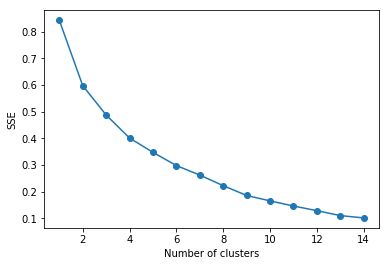

In [15]:
#Dropping the neighborhood column which is not needed in the clustering process
leuven_grouped_clustering = leuven_grouped.drop('Neighborhood', 1)

SSE_vec=[] #Initialising list for SSE
kmeans_mods=[]  #Initialising list for K-means clustering models
for k in range(1,15):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(leuven_grouped_clustering)
    SSE_vec.append(kmeans.inertia_)
    kmeans_mods.append(kmeans)

# plotting the intra SSE versus the number of clusters
plt.plot(range(1, 15), SSE_vec, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Adding the cluster labels to the data set

In [21]:
leuven_grouped["Clusters"]=kmeans_mods[4].labels_ #Obtaining the the 5 labels of the 5 clusters and adding to the dataframe
cols = leuven_grouped.columns.tolist()
cols = cols[-1:] + cols[:-1]   #Pushing the Cluster labels to the first column
leuven_grouped=leuven_grouped[cols]
leuven_grouped.head()

,Clusters,Neighborhood,ATM,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Beer Bar,Belgian Restaurant,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brasserie,Breakfast Spot,Bridge,Burger Joint,Burrito Place,Bus Stop,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Dance Studio,Discount Store,Doner Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Film Studio,Fish & Chips Shop,Flower Shop,Fondue Restaurant,Food Court,Food Service,French Restaurant,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,Hostel,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Lawyer,Lounge,Market,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Museum,Music Store,Nightclub,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Print Shop,Pub,Radio Station,Record Shop,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,1,'t Archief,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.010000,0.120000,0.030000,0.000000,0.030000,0.01,0.010000,0.0,0.010000,0.03,0.02,0.0,0.030000,0.01,0.0,0.01,0.0,0.010000,0.010000,0.04,0.100000,0.0,0.000000,0.0,0.0,0.010000,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.010000,0.0,0.000000,0.0,0.0,0.03,0.000000,0.01,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.010000,0.0,0.0,0.020000,0.0,0.030000,0.0,0.0,0.0,0.01,0.05000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.010000,0.02,0.0,0.0,0.000000,0.0,0.000000,0.01,0.000000,0.0,0.0,0.00,0.010000,0.0,0.01,0.01,0.0,0.0,0.01,0.000000,0.020000,0.0,0.0,0.040000,0.01,0.0,0.0,0.0,0.00,0.0,0.010000,0.01,0.00,0.0,0.010000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.000000,0.0,0.030000,0.01,0.0,0.01,0.0,0.010000,0.000000,0.01,0.0,0.0,0.010000,0.00,0.01,0.000000,0.01
1,4,'t Fonduehuisje,0.0,0.0,0.010000,0.0,0.0,0.00,0.0,0.0,0.000000,0.070000,0.030000,0.010000,0.020000,0.00,0.010000,0.0,0.020000,0.02,0.00,0.0,0.030000,0.00,0.0,0.01,0.0,0.020000,0.040000,0.00,0.070000,0.0,0.000000,0.0,0.0,0.020000,0.020000,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,0.010000,0.010000,0.010000,0.0,0.010000,0.0,0.0,0.01,0.010000,0.01,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.010000,0.0,0.0,0.010000,0.0,0.0,0.010000,0.0,0.030000,0.0,0.0,0.0,0.00,0.06000,0.0,0.0,0.0,0.0,0.010000,0.010000,0.0,0.0,0.020000,0.01,0.0,0.0,0.010000,0.0,0.000000,0.01,0.000000,0.0,0.0,0.01,0.010000,0.0,0.00,0.01,0.0,0.0,0.01,0.010000,0.030000,0.0,0.0,0.040000,0.01,0.0,0.0,0.0,0.01,0.0,0.020000,0.01,0.00,0.0,0.020000,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.000000,0.0,0.040000,0.00,0.0,0.01,0.0,0.010000,0.000000,0.01,0.0,0.0,0.010000,0.00,0.00,0.010000,0.01
2,4,'t Fritwinkeltje,0.0,0.0,0.016393,0.0,0.0,0.00,0.0,0.0,0.016393,0.065574,0.016393,0.016393,0.016393,0.00,0.016393,0.0,0.032787,0.00,0.00,0.0,0.016393,0.00,0.0,0.00,0.0,0.016393,0.065574,0.00,0.081967,0.0,0.016393,0.0,0.0,0.032787,0.016393,0.0,0.0,0.016393,0.0,0.0,0.0,0.0,0.016393,0.016393,0.016393,0.0,0.016393,0.0,0.0,0.00,0.016393,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.016393,0.0,0.

In [22]:
print("The following 5 cluster labels seem to be the most optimal: ",list(set(kmeans_mods[4].labels_)))
print("There are {} clusters".format(len(list(set(kmeans_mods[4].labels_)))))

The following 5 cluster labels seem to be the most optimal:  [0, 1, 2, 3, 4]
There are 5 clusters


In [23]:
#Distribution of neighborhoods in the 5 clusters
leuven_grouped[["Clusters","Neighborhood"]].groupby("Clusters").count().reset_index()

,Clusters,Neighborhood
0,0,4
1,1,64
2,2,13
3,3,5
4,4,13


In order to make a visualisation of the clustered neighborhoods, the data with the cluster labels will be merged with the data having the geolocation

In [29]:
#Merging the data with cluster information with that having lattitude and longitude information
merged_LL=pd.merge(Leuven_venues.drop(columns=["Venue Latitude","Venue Longitude","Venue"]),leuven_grouped,left_on="Neighborhood",
                   right_on="Neighborhood",how="left")


The following map shows the distribution of the clustered neighborhoods on the Leuven map

In [ ]:
# create map
map_clusters = folium.Map(location=[Leuven_lat, Leuven_long], zoom_start=15)

# set color scheme for the clusters
kclusters=5
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nh, cluster in zip(merged_LL['Neighborhood Latitude'], merged_LL['Neighborhood Longitude'], merged_LL['Neighborhood'], merged_LL['Clusters']):
    label = folium.Popup(str(nh) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Characterising the Clusters

In [31]:
#Obtaining the means (centres) per cluster
cluster_means=leuven_grouped.drop(columns="Neighborhood").groupby("Clusters",as_index=False).mean()
cluster_means

,Clusters,ATM,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Badminton Court,Bakery,Bar,Beer Bar,Belgian Restaurant,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brasserie,Breakfast Spot,Burger Joint,Burrito Place,Bus Stop,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cultural Center,Dance Studio,Discount Store,Doner Restaurant,Electronics Store,Event Space,Falafel Restaurant,Film Studio,Fish & Chips Shop,Fondue Restaurant,Food Court,Forest,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Furniture / Home Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Herbs & Spices Store,Historic Site,Hostel,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Laundromat,Lawyer,Lounge,Market,Mattress Store,Men's Store,Mexican Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Museum,Music Store,Noodle House,Notary,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pie Shop,Piercing Parlor,Pizza Place,Platform,Plaza,Poke Place,Pool Hall,Print Shop,Pub,Radio Station,Record Shop,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Science Museum,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019248,0.168478,0.003623,0.000000,0.000000,0.019248,0.000000,0.000000,0.000000,0.019248,0.019248,0.026495,0.003623,0.000000,0.000000,0.019248,0.019248,0.000000,0.026495,0.054574,0.000000,0.000000,0.019248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019248,0.000000,0.038496,0.000000,0.003623,0.000000,0.019248,0.019248,0.038496,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.003623,0.000000,0.000000,0.000000,0.019248,0.019248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038496,0.000000,0.019248,0.019248,0.000000,0.0000,0.000000,0.000000,0.022871,0.022871,0.019248,0.000000,0.000000,0.019248,0.000000,0.019248,0.000000,0.000000,0.000000,0.038496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019248,0.000000,0.010870,0.019248,0.000000,0.000000,0.014040,0.019248,0.000000,0.000000,0.000000,0.019248,0.019248,0.000000,0.000000,0.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.003600,0.000000,0.000000,0.011200,0.126000,0.027600,0.000000,0.032000,0.009600,0.006000,0.000000,0.009600,0.026000,0.012800,0.040000,0.010000,0.000000,0.006400,0.000400,0.010000,0.007200,0.036000,0.098000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.026400,0.000000,0.007200,0.008800,0.000000,0.000000,0.009600,0.004400,0.000000,0.000000,0.004800,0.000000,0.010000,0.000000,0.000000,0.012000,0.000000,0.030000,0.000000,0.004000,0.010000,0.060800,0.000000,0.000000,0.00000,0.000000,0.007200,0.000000,0.006400,0.019600,0.000400,0.000000,0.007200,0.002800,0.010000,0.000000,0.000000,0.000000,0.000000,0.007200,0.000000,0.010400,0.000400,0.002800,0.000400,0.000000,0.0000,0.018400,0.000000,0.028000,0.019600,0.001200,0.000000,0.005600,0.000800,0.010000,0.009600,0.000000,0.015600,0.000000,0.011200,0.000000,0.000000,0.000000,0.000000,0.014400,0.000000,0.000000,0.000000,0.006000,0.000000,0.035600,0.00240

In [32]:
print("{} venue categories".format(len(list(cluster_means.drop(columns="Clusters")))))

130 venue categories


To characterise the clusters, neighborhoods with feature means (centres) greater than the overall cluster mean (overall centre) will be used to characterise the cluster. It should be noted that the printed features are in alphabetical order and not in order of influence

In [68]:
attributes_avg=list(cluster_means.drop(columns="Clusters").mean()) #Overall means for each feature
features=list(cluster_means.drop(columns="Clusters")) #List of all features used for clustering

characters_clust=[[],[],[],[],[]]

#Characterising the clusters with features having a cluster mean greater than the overall feature mean
for col in range(0,len(features)):
    for row in range(0,len(cluster_means)):
        if cluster_means.iloc[row,col]>attributes_avg[col]:
            characters_clust[row].append(features[col])

for label in range(0,len(cluster_means)):
    print("{} Characteristics of cluster {}: ".format(len(list(set(characters_clust[label]))),label+1),characters_clust[label])
    print(" ")

34 Characteristics of cluster 1:  ['Beer Bar', 'Belgian Restaurant', 'Bookstore', 'Breakfast Spot', 'Burrito Place', 'Chocolate Shop', 'Clothing Store', 'Concert Hall', 'Cosmetics Shop', 'Fried Chicken Joint', 'Hostel', 'IT Services', 'Indian Restaurant', 'Irish Pub', 'Japanese Restaurant', 'Miscellaneous Shop', 'Noodle House', 'Notary', 'Pastry Shop', 'Pharmacy', 'Pie Shop', 'Poke Place', 'Pool Hall', 'Print Shop', 'Record Shop', 'Road', 'Science Museum', 'Supermarket', 'Syrian Restaurant', 'Tapas Restaurant', 'Theater', 'Thrift / Vintage Store', 'Vietnamese Restaurant', 'Wine Bar']
 
43 Characteristics of cluster 2:  ['ATM', 'Baby Store', 'Beer Bar', 'Belgian Restaurant', 'Board Shop', 'Bookstore', 'Botanical Garden', 'Breakfast Spot', 'Burrito Place', 'Bus Stop', 'Concert Hall', 'Creperie', 'Fondue Restaurant', 'Fried Chicken Joint', 'Frozen Yogurt Shop', 'Furniture / Home Store', 'Gourmet Shop', 'Hardware Store', 'Historic Site', 'IT Services', 'Indian Restaurant', 'Japanese Restau

There are an ernomous number of features to report (over 50), so the top most and least influential features will be reported

Displaying the top most influential features per cluster

In [61]:
for cluster in range(0,len(characters_clust)):
    features=characters_clust[cluster]
    Cluster_df=cluster_means[features].iloc[cluster,:].to_frame().transpose().sort_values(by=cluster,axis=1,ascending=False)
    print(" ")
    print("Top 10 most influential features in cluster {}: ".format(cluster+1),list(Cluster_df.columns.values)[0:9])



 
Top 10 most influential features in cluster 1:  ['Poke Place', 'Pharmacy', 'Irish Pub', 'Vietnamese Restaurant', 'Breakfast Spot', 'Chocolate Shop', 'Pool Hall', 'Theater', 'Noodle House']
 
Top 10 most influential features in cluster 2:  ['Beer Bar', 'Poke Place', 'Breakfast Spot', 'Burrito Place', 'Board Shop', 'Restaurant', 'Frozen Yogurt Shop', 'Bookstore', 'Vietnamese Restaurant']
 
Top 10 most influential features in cluster 3:  ['Clothing Store', 'Beer Bar', 'Cocktail Bar', 'Fondue Restaurant', 'Breakfast Spot', 'Poke Place', 'Belgian Restaurant', 'Restaurant', 'Frozen Yogurt Shop']
 
Top 10 most influential features in cluster 4:  ['Beer Bar', 'Breakfast Spot', 'Gourmet Shop', 'Board Shop', 'Bookstore', 'Burrito Place', 'Pastry Shop', 'Miscellaneous Shop', 'Fish & Chips Shop']
 
Top 10 most influential features in cluster 5:  ['Grocery Store', 'Pub', 'Indian Restaurant', 'Sushi Restaurant', 'Print Shop', 'Pool Hall', 'Lawyer', 'Laundromat', 'Electronics Store']


Displaying the least influential features per cluster

In [ ]:
for cluster in range(0,len(characters_clust)):
    features=characters_clust[cluster]
    Cluster_df=cluster_means[features].iloc[cluster,:].to_frame().transpose().sort_values(by=cluster,axis=1,ascending=True)
    print(" ")
    print("Top 10 least influential features in cluster {}: ".format(cluster+1),list(Cluster_df.columns.values)[0:9])

# Multivariate Statistical test : MANOVA

This test was used to further confirm that the clusters were distinct from each other. This will first begin with dimension reduction by principal component anlysis (PCA) whose new dimensions will be used as the new dependent variables in one-way multivariate analysis of variance (MANOVA).

In [36]:
manova_feat=list(leuven_grouped.columns.values) #Extracting the feature names
X = np.array(leuven_grouped[manova_feat[2:]]) #To be used in PCA
y = np.array(leuven_grouped[manova_feat[0]]) #To be used as independent variable

The find the appropriate number of principal components, the "elbow joint" method was applied on the explained variance versus number of principal components

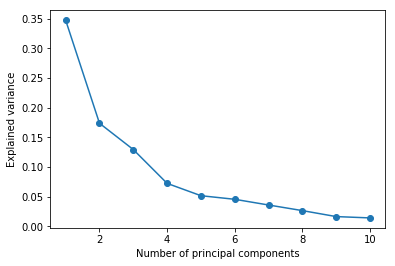

In [37]:
pca = PCA(n_components = 10) 
  
X_pc = pca.fit_transform(X)  
  
explained_variance = pca.explained_variance_ratio_ 
explained_variance
# plotting the intra SSE versus the number of clusters
plt.plot(range(1, 11), explained_variance, marker='o')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance')
plt.show()

The newly created principal components were used as the new dependent variables in the MANOVA analysis. The original variables could not be used because they show evidence of that the model matrix can't be inverted as the number of variables were greater than the number of observations. In addition, multidimensional data usually show evidence of multicollinearity which could lead to poor estimation of the model.

In [38]:
pca=PCA(n_components=4)
X_pc=pca.fit_transform(X)
manova = MANOVA(endog=X_pc, exog=y)
print(manova.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
           x0           Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.8550 4.0000 95.0000  4.0267 0.0046
         Pillai's trace 0.1450 4.0000 95.0000  4.0267 0.0046
 Hotelling-Lawley trace 0.1695 4.0000 95.0000  4.0267 0.0046
    Roy's greatest root 0.1695 4.0000 95.0000  4.0267 0.0046

